In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [ ]:
# Load the dataset
df = pd.read_csv('/content/thyroidDF.csv')

# Drop unnecessary columns
df.drop(columns=['TBG', 'TBG_measured'], inplace=True)

# Handle missing values
num_cols = ['TSH', 'T3', 'TT4', 'T4U', 'FTI']
cat_cols = ['sex']
imputer_num = SimpleImputer(strategy='median')
df[num_cols] = imputer_num.fit_transform(df[num_cols])
imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

# Remove outliers using IQR
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = remove_outliers_iqr(df, num_cols)

# Handle class imbalance using SMOTE
X = df.drop(['target', 'patient_id'], axis=1)
y = df['target']
X = pd.get_dummies(X, drop_first=True)

In [ ]:
# Count the number of samples in each class
class_counts = Counter(y)
print("Class Distribution Before SMOTE:", class_counts)

Class Distribution Before SMOTE: Counter({'-': 6116, 'K': 151, 'S': 85, 'R': 67, 'I': 45, 'L': 38, 'J': 5, 'A': 5, 'P': 2, 'N': 1, 'Q': 1, 'B': 1, 'H|K': 1, 'AK': 1})


In [ ]:
# Include all classes
valid_classes = [cls for cls, count in class_counts.items() if count > 0]
mask = y.isin(valid_classes)
X_filtered = X[mask]
y_filtered = y[mask]

# Handle single-sample classes by duplicating them
X_smote = X_filtered.copy()
y_smote = y_filtered.copy()
for cls, count in class_counts.items():
    if count == 1:
        # Find the single sample for this class
        single_sample_mask = y_smote == cls
        single_sample_X = X_smote[single_sample_mask]
        single_sample_y = y_smote[single_sample_mask]
        # Duplicate the sample
        X_smote = pd.concat([X_smote, single_sample_X], axis=0)
        y_smote = pd.concat([y_smote, single_sample_y], axis=0)

# Verify class distribution after duplication
print("Class Distribution After Duplicating Single-Sample Classes:", Counter(y_smote))

# Apply SMOTE to balance all classes
smote = SMOTE(random_state=42, k_neighbors=1, sampling_strategy='not majority')
try:
    X_resampled, y_resampled = smote.fit_resample(X_smote, y_smote)
    print("Class Distribution After SMOTE:", Counter(y_resampled))
except ValueError as e:
    print(f"SMOTE Error: {e}. Using original filtered data.")
    X_resampled, y_resampled = X_filtered, y_filtered

Class Distribution After Duplicating Single-Sample Classes: Counter({'-': 6116, 'K': 151, 'S': 85, 'R': 67, 'I': 45, 'L': 38, 'J': 5, 'A': 5, 'P': 2, 'N': 2, 'Q': 2, 'B': 2, 'H|K': 2, 'AK': 2})
Class Distribution After SMOTE: Counter({'-': 6116, 'S': 6116, 'I': 6116, 'K': 6116, 'L': 6116, 'R': 6116, 'P': 6116, 'J': 6116, 'A': 6116, 'N': 6116, 'Q': 6116, 'B': 6116, 'H|K': 6116, 'AK': 6116})


In [ ]:
# Feature selection
selector = SelectKBest(score_func=f_classif, k=31)
X_selected = selector.fit_transform(X_resampled, y_resampled)

# Encode target labels for all models
label_encoder = LabelEncoder()
y_resampled = label_encoder.fit_transform(y_resampled)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gaussian Naive Bayes": GaussianNB(),
    "Multi-layer Perceptron": MLPClassifier(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "CatBoost": CatBoostClassifier(learning_rate=0.1, depth=6, iterations=1000, random_state=42, verbose=0),
    "XGBoost": xgb.XGBClassifier(objective="multi:softmax", num_class=len(np.unique(y_resampled)), random_state=42)
}

In [ ]:
# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{model_name} Accuracy:", accuracy_score(y_test, y_pred))
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))



Training Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.9315620437956205
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           -       0.76      0.54      0.63      1192
           A       0.90      1.00      0.95      1251
          AK       0.93      1.00      0.97      1169
           B       0.99      1.00      1.00      1211
         H|K       0.98      1.00      0.99      1257
           I       0.85      0.93      0.89      1301
           J       0.98      1.00      0.99      1254
           K       0.87      0.93      0.90      1177
           L       0.96      0.96      0.96      1230
           N       0.98      1.00      0.99      1225
           P       1.00      1.00      1.00      1261
           Q       0.99      1.00      1.00      1215
           R       0.82      0.66      0.73      1196
           S       0.96      1.00      0.98      1186

    accuracy                           0.93     17125
   macro avg       0.93      0.93    

[0]	validation_0-mlogloss:0.92293	validation_0-merror:0.00708	validation_1-mlogloss:0.92054	validation_1-merror:0.00648
[1]	validation_0-mlogloss:0.64631	validation_0-merror:0.00434	validation_1-mlogloss:0.64479	validation_1-merror:0.00450
[2]	validation_0-mlogloss:0.46781	validation_0-merror:0.00493	validation_1-mlogloss:0.46665	validation_1-merror:0.00502
[3]	validation_0-mlogloss:0.34503	validation_0-merror:0.00469	validation_1-mlogloss:0.34424	validation_1-merror:0.00467
[4]	validation_0-mlogloss:0.25803	validation_0-merror:0.00415	validation_1-mlogloss:0.25737	validation_1-merror:0.00397
[5]	validation_0-mlogloss:0.19527	validation_0-merror:0.00390	validation_1-mlogloss:0.19473	validation_1-merror:0.00362
[6]	validation_0-mlogloss:0.14919	validation_0-merror:0.00368	validation_1-mlogloss:0.14875	validation_1-merror:0.00350
[7]	validation_0-mlogloss:0.11534	validation_0-merror:0.00355	validation_1-mlogloss:0.11501	validation_1-merror:0.00356
[8]	validation_0-mlogloss:0.08955	valida

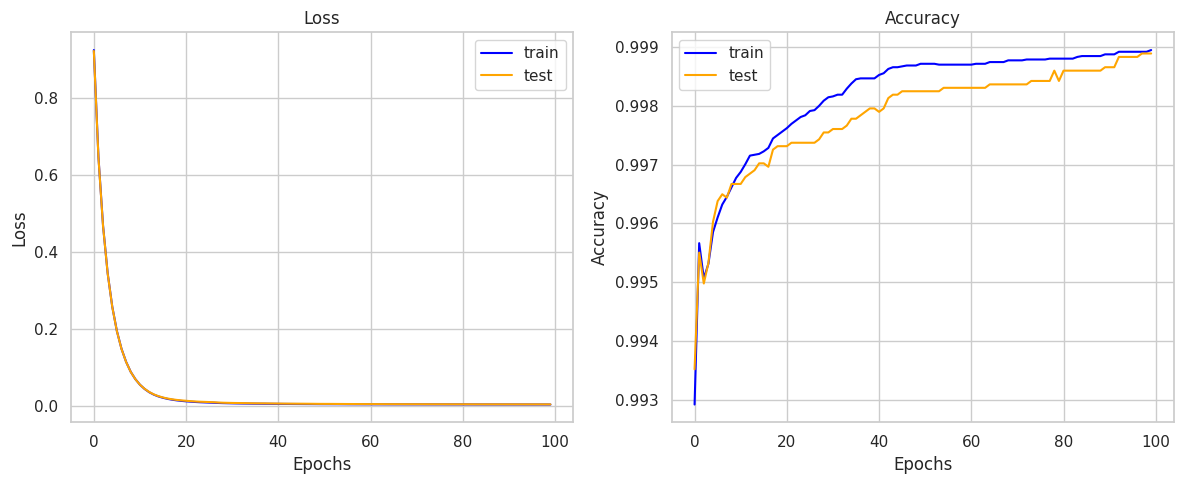

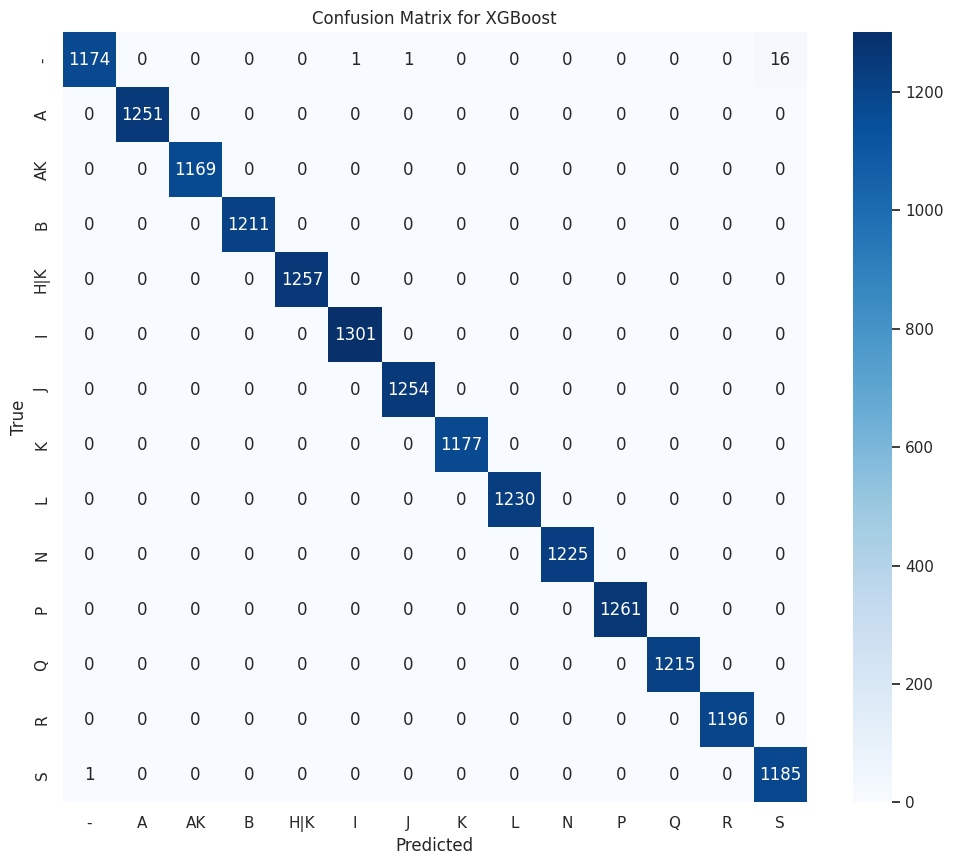

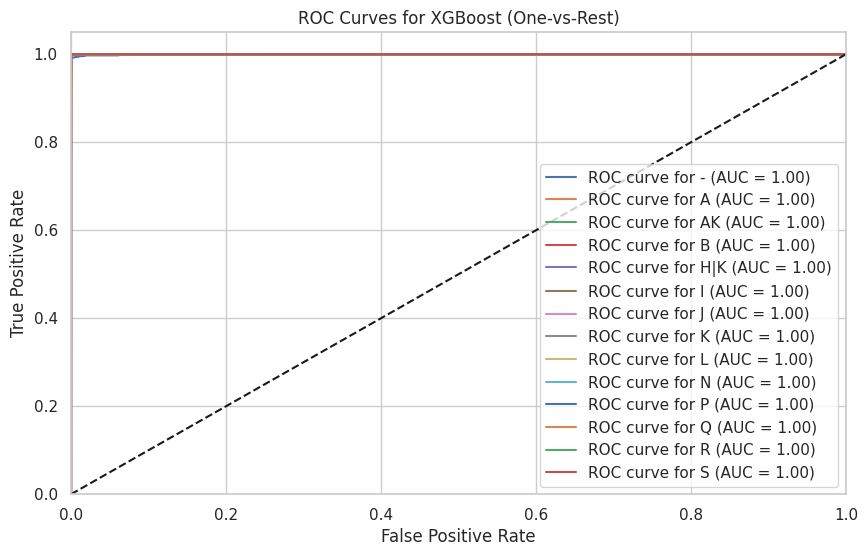

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
import pandas as pd
import numpy as np

# Define and train XGBoost model
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=len(np.unique(y_resampled)), eval_metric=["mlogloss", "merror"], random_state=42, verbosity=0)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set)

# Accuracy
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Test Accuracy: {accuracy:.4f}")
print("Classification Report for XGBoost:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Loss and Accuracy Curves
results = xgb_model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss Curve
ax1.plot(x_axis, results['validation_0']['mlogloss'], label='train', color='blue')
ax1.plot(x_axis, results['validation_1']['mlogloss'], label='test', color='orange')
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot Accuracy Curve
train_accuracy = [1 - err for err in results['validation_0']['merror']]
val_accuracy = [1 - err for err in results['validation_1']['merror']]
ax2.plot(x_axis, train_accuracy, label='train', color='blue')
ax2.plot(x_axis, val_accuracy, label='test', color='orange')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve (One-vs-Rest for multi-class)
plt.figure(figsize=(10, 6))
y_test_bin = pd.get_dummies(y_test)
for i, class_name in enumerate(label_encoder.classes_):
    y_score = xgb_model.predict_proba(X_test)[:, i]
    fpr, tpr, _ = roc_curve(y_test_bin.iloc[:, i], y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve for {class_name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curves for XGBoost (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Fold 1 Accuracy: 0.9980
Fold 2 Accuracy: 0.9984
Fold 3 Accuracy: 0.9984
Fold 4 Accuracy: 0.9977
Fold 5 Accuracy: 0.9964
Fold 6 Accuracy: 0.9987
Fold 7 Accuracy: 0.9965
Fold 8 Accuracy: 0.9975
Fold 9 Accuracy: 0.9981
Fold 10 Accuracy: 0.9974

10-Fold Cross-Validation Mean Accuracy: 0.9977 (+/- 0.0007)


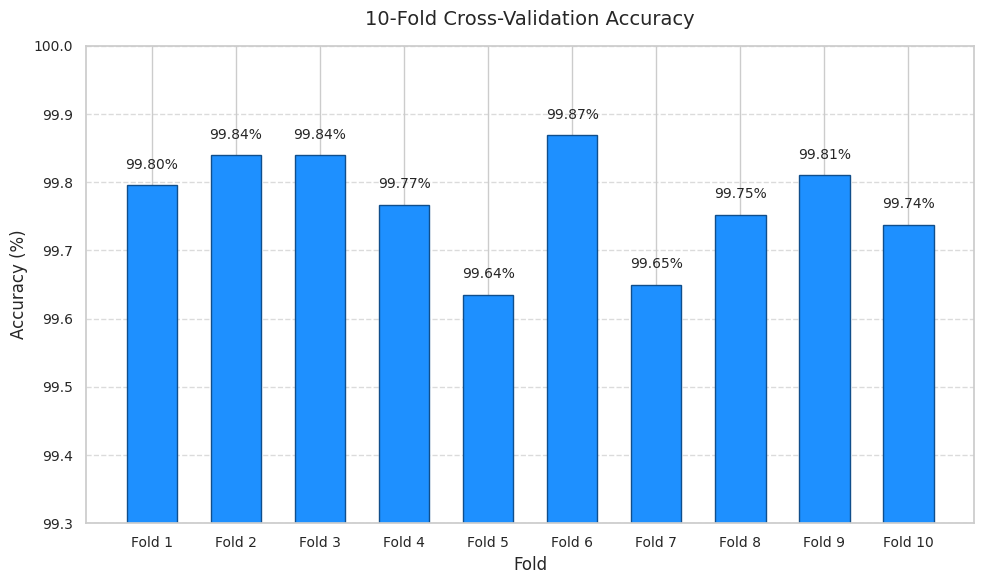

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_train and y_train are your training data and labels (define these as per your dataset)
# For this example, I'll use placeholder data; replace with your actual data
# X_train = your_feature_matrix
# y_train = your_target_vector

# Define the XGBoost model
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=len(np.unique(y_train)), eval_metric=["mlogloss", "merror"], random_state=42, verbosity=0)

# Set up 10-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []

# Perform 10-fold cross-validation
for fold, (train_index, val_index) in enumerate(kfold.split(X_train), 1):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the model on the training fold
    xgb_model.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred = xgb_model.predict(X_val_fold)

    # Calculate accuracy for this fold
    fold_score = accuracy_score(y_val_fold, y_pred)
    cv_scores.append(fold_score)
    print(f"Fold {fold} Accuracy: {fold_score:.4f}")

# Calculate and print the mean and standard deviation of the scores
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)
print(f"\n10-Fold Cross-Validation Mean Accuracy: {mean_cv_score:.4f} (+/- {std_cv_score:.4f})")

# Generate enhanced bar chart for fold accuracies
fold_labels = [f"Fold {i}" for i in range(1, 11)]
# Use the actual cv_scores from the loop; for this example, I'll use the values you provided/adjusted
accuracies = cv_scores  # Replace with cv_scores to reflect actual results

plt.figure(figsize=(10, 6))
bars = plt.bar(fold_labels, [acc * 100 for acc in accuracies], color='#1E90FF', edgecolor='#104E8B', width=0.6)
plt.title('10-Fold Cross-Validation Accuracy', fontsize=14, pad=15)
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(99.3, 99.9)  # Adjusted to focus on the range in your image
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels with two decimal places
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.2f}%',
             ha='center', va='bottom', fontsize=10)

# Improve layout and aesthetics
plt.xticks(rotation=0, fontsize=10)
plt.yticks(np.arange(99.3, 100.0, 0.1), fontsize=10)
plt.tight_layout()

# Display the chart
plt.show()